In [1]:
pwd

'/Users/dmarx/proj/ComfyUI'

In [7]:
from copy import deepcopy
from colorsys import rgb_to_hls
from PIL import Image
import json
#from urllib import request, parse
import random
import requests
from pathlib import Path
import uuid
import numpy as np
from colorspacious import cspace_convert, cspace_converter
import sklearn
from sklearn.cluster import KMeans

In [3]:
def queue_prompt(prompt):
    p = {"prompt": prompt, "client_id": client_id}
    data = json.dumps(p).encode('utf-8')
    req =  urllib.request.Request("http://{}/prompt".format(server_address), data=data)
    return json.loads(urllib.request.urlopen(req).read())

def get_image(filename, subfolder, folder_type):
    data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    url_values = urllib.parse.urlencode(data)
    with urllib.request.urlopen("http://{}/view?{}".format(server_address, url_values)) as response:
        return response.read()

def get_history(prompt_id):
    with urllib.request.urlopen("http://{}/history/{}".format(server_address, prompt_id)) as response:
        return json.loads(response.read())

In [4]:


server_address = "127.0.0.1:8188"
client_id = str(uuid.uuid4())


#workflow_name = "face-palette_v0.4"
workflow_name = "workflow_api"

def load_workflow(
    workflow_name, 
    #comfy_root = Path('/Users/dmarx/proj/ComfyUI'),
    #workflow_root = comfy_root / "pysssss-workflows",
    workflow_root=Path('/Users/dmarx/Downloads')
):
    fp_workflow = workflow_root / f"{workflow_name}.json"
    with open(fp_workflow) as f:
        return json.load(f)

workflow = load_workflow(workflow_name)

/Users/dmarx/proj/ComfyUI/_venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
def get_node_by_properties(workflow, node_properties):
    nodes = workflow.get('nodes', workflow.values())
    for node in nodes:
        if all(node.get(k) == v for k,v in node_properties.items()):
            return node

def get_prompt_node(workflow):
    return get_node_by_properties(workflow, {'class_type':'CLIPTextEncode', 'color': '#232'})

def set_seed(workflow, seed):
    sampler = get_node_by_properties(workflow, {'class_type':'KSampler'})
    print(sampler)
    #sampler['widgets_values'][0] = seed
    sampler['inputs']['seed'] = seed

set_seed(workflow,42)
#get_node_by_properties(workflow, {'type':'KSampler'})

#prompt_node = get_prompt_node(workflow)
#prompt_node

{'inputs': {'seed': 930292204097952, 'steps': 18, 'cfg': 5, 'sampler_name': 'dpmpp_2m', 'scheduler': 'normal', 'denoise': 1, 'model': ['67', 0], 'positive': ['157', 0], 'negative': ['157', 1], 'latent_image': ['5', 0]}, 'class_type': 'KSampler'}


In [6]:
#ok, now we good.
# 1. workflow needs to be in API format
# 2. needs to be a POST request

set_seed(workflow,44)

payload = dict(
    prompt=workflow,
    client_id=client_id,
)
#payload = json.dumps(workflow)
payload = json.dumps(payload).encode('utf-8')

submit_url = f"http://{server_address}/prompt"
history_url = f"http://{server_address}/history"




response = requests.post(submit_url, data=payload)
response

prompt_id = response.json()['prompt_id']
prompt_id

{'inputs': {'seed': 42, 'steps': 18, 'cfg': 5, 'sampler_name': 'dpmpp_2m', 'scheduler': 'normal', 'denoise': 1, 'model': ['67', 0], 'positive': ['157', 0], 'negative': ['157', 1], 'latent_image': ['5', 0]}, 'class_type': 'KSampler'}


'2d859c5d-5f55-429b-906a-083c2a8ded18'

In [116]:
# # oh. that actually worked this time.

# def queue_prompt(prompt):
#     p = {"prompt": prompt}
#     data = json.dumps(p).encode('utf-8')
#     req =  request.Request("http://127.0.0.1:8188/prompt", data=data)
#     response = request.urlopen(req)
#     return response

response.json()

{'prompt_id': '2a46eaa1-8eb6-4139-bd7e-4712641a3e4d',
 'number': 14,
 'node_errors': {}}

In [109]:
response

In [119]:
history_url = f"http://{server_address}/history"
requests.get(history_url).json()[prompt_id]
# to do: given prompt_id, get filenames for generated image and inferred masks

{'prompt': [51,
  '1f70be60-06df-468f-b5f9-e4fb786bcc9f',
  {'3': {'inputs': {'seed': 44,
     'steps': 18,
     'cfg': 5.0,
     'sampler_name': 'dpmpp_2m',
     'scheduler': 'normal',
     'denoise': 1.0,
     'model': ['67', 0],
     'positive': ['157', 0],
     'negative': ['157', 1],
     'latent_image': ['5', 0]},
    'class_type': 'KSampler'},
   '4': {'inputs': {'ckpt_name': 'CyberRealistic_/cyberrealistic_v31.safetensors'},
    'class_type': 'CheckpointLoaderSimple'},
   '5': {'inputs': {'width': 576, 'height': 576, 'batch_size': 1},
    'class_type': 'EmptyLatentImage'},
   '8': {'inputs': {'samples': ['3', 0], 'vae': ['4', 2]},
    'class_type': 'VAEDecode'},
   '27': {'inputs': {'text': 'hat, drawing, nude, nsfw, text, watermark, mutated, deformed, grotesque, confusing, retarded, amputee stump, asian, strong legs, anorexic, detached limb, extra limbs, anal, weird legs, trap, polydactyl, prolapsed, jowls',
     'clip': ['59', 0]},
    'class_type': 'CLIPTextEncode'},
   '54'

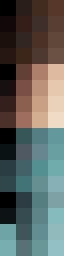

In [155]:
palette = Image.open("output/ComfyUI_00039_.png")
mini_palette = palette.resize((4,16), Image.Resampling.NEAREST)
mini_palette.resize((64, 256), Image.Resampling.NEAREST)

In [158]:
#from PIL import ImageColor
#dir(ImageColor)
#palette.convert('HSL') # well. fml.
palette_hsv = mini_palette.convert('HSV')


np.array(palette_hsv).shape # 16 4 3
np.array(palette_hsv)[:,:,0]

array([[  0,  14,  12,  13],
       [  9,  11,  13,  13],
       [ 10,  14,  12,  14],
       [ 12,  12,  13,  14],
       [  0,   9,  12,  19],
       [  9,  10,  14,  20],
       [  8,  11,  16,  20],
       [  9,  11,  18,  21],
       [  0, 128, 131, 129],
       [127, 140, 134, 129],
       [133, 132, 128, 128],
       [133, 129, 129, 132],
       [  0, 137, 130, 131],
       [127, 132, 130, 129],
       [127, 132, 129, 129],
       [127, 132, 128, 130]], dtype=uint8)

In [354]:
# https://github.com/CairX/convert-colors-py/blob/master/convcolors/__init__.py

x = np.array([[[.01,.02,.03],[.04,.05,.06]]])
#print(x.shape)

def _pivot_rgb_to_xyz(x):
    idx0 = np.where(x<=0.04045)
    idx1 = np.where(x>0.04045)
    x[idx0] = x[idx0] / 12.92
    x[idx1] = np.power( (x[idx1] + 0.055) / 1.055, 2.4)
    return x


def _pivot_xyz_to_rgb(x):
    idx0 = np.where(x<=0.0031308)
    idx1 = np.where(x>0.0031308)
    x[idx0] = x[idx0] * 12.92
    x[idx1] = (np.power(x[idx1], 0.4166666)  * 1.055) - 0.055
    return x
    
def _pivot_xyz_to_lab(x):
    # if value > 0.008856:
    #     value = math.pow(value, 0.3333333)
    # else:
    #     value = ((value * 903.3) + 16.0) / 116.0
    # return value
    idx0 = np.where(x<=0.008856)
    idx1 = np.where(x>0.008856)
    x[idx0] = ((x[idx0] * 903.3) + 16.0) / 116.0
    #x[idx1] = np.power(x[idx1], 1/3)
    x[idx1] = np.power(x[idx1], 0.3333333)
    return x


def rgb_to_xyz(rgb):
    rgb = rgb / 255
    rgb = _pivot_rgb_to_xyz(rgb)
    M = np.array([ 
         [ 0.4124564 , 0.3575761 , 0.1804375],
         [ 0.2126729 , 0.7151522 , 0.0721750],
         [ 0.0193339 , 0.1191920 , 0.9503041]])
    xyz = rgb @ M.T
    return xyz*100


def xyz_to_rgb(xyz):
    xyz = xyz / 100
    M = np.array([
        [3.2404542 , -1.5371385 , -0.4985314],
        [-0.9692660 , 1.8760108 , 0.0415560],
        [0.0556434 , -0.2040259 , 1.0572252]])
    rgb = xyz @ M.T
    rgb = _pivot_xyz_to_rgb(rgb)
    return rgb * 255

################################################

def xyz_to_lab(xyz):
    # x = xyz[0] / 95.047
    # y = xyz[1] / 100.000
    # z = xyz[2] / 108.883
    xyz = xyz / np.array([95.047, 100, 108.883])
    #print(xyz)
    
    # x = _pivot_xyz_to_lab(x)
    # y = _pivot_xyz_to_lab(y)
    # z = _pivot_xyz_to_lab(z)

    xyz = _pivot_xyz_to_lab(xyz) # pretty sure this is working correctly...
    #print(xyz)
    # l = max(0.0, (116.0 * y) - 16.0)
    # a = (x - y) * 500.0
    # b = (y - z) * 200.0
    x,y,z = xyz[:,:,0], xyz[:,:,1], xyz[:,:,2]
    #print(y)
    l = np.fmax(0.0, (116.0 * y) - 16.0)
    #print(l)
    a = (x - y) * 500.0
    b = (y - z) * 200.0

    # return l, a, b
    lab= np.array([l,a,b])
    lab = lab.reshape(*xyz.shape)
    return lab

################################################


def lab_to_xyz(lab):
    # l = lab[0]
    # a = lab[1]
    # b = lab[2]
    l, a, b = lab[:,:, 0], lab[:,:, 1], lab[:,:, 2]

    # # Reminder: The y values is calculated first as it can be reused
    # # for the calculation of x and z.
    y = (l + 16.0) / 116.0
    x = y + (a / 500.0)
    z = y - (b / 200.0)
    

    x3 = x * x * x
    y3 = y * y * y
    z3 = z * z * z

    # x = x3 if x3 > 0.008856 else ((x * 116.0) - 16.0) / 903.3
    #print(x3.shape)
    x_idx0 = np.where(x3 > 0.008856)
    #print(x_idx0.shape)
    #print(x_idx0)
    x_idx1 = np.where(x3 <= 0.008856)
    x[x_idx0] = x3[x_idx0]
    x[x_idx1] = ((x[x_idx1] * 116.0) - 16.0) / 903.3

    # y = (y * y * y) if l > 7.9996248 else l / 903.3
    y_idx0 = np.where(l > 7.9996248)
    y_idx1 = np.where(l <= 7.9996248)
    y[y_idx0] = y3[y_idx0]
    y[y_idx1] = l[y_idx1] / 903.3

    # z = z3 if z3 > 0.008856 else ((z * 116.0) - 16.0) / 903.3
    z_idx0 = np.where(z3 > 0.008856)
    z_idx1 = np.where(z3 <= 0.008856)
    z[z_idx0] = z3[z_idx0]
    z[z_idx1] = ((z[z_idx1] * 116.0) - 16.0) / 903.3


    x = x * 95.047
    y = y * 100.000
    z = z * 108.883

    # return x, y, z
    xyz = np.array([x,y,z]).reshape(*lab.shape)
    return xyz


################################################

def rgb_to_lab(rgb):
    """
    Convert tuple from the sRGB color space to the CIE L*a*b* color space.
    Shorthand method for chaining sRGB => CIE XYZ => CIE L*a*b*.
    """
    return xyz_to_lab(rgb_to_xyz(rgb))


def lab_to_rgb(lab):
    """
    Convert tuple from the CIE L*a*b* color space to the sRGB color space.
    Shorthand method for chaining CIE L*a*b* => CIE XYZ  => sRGB.
    """
    return xyz_to_rgb(lab_to_xyz(lab))



################################################


#rgb_to_xyz(x)
#rgb_to_xyz(np.array([.01,.02,.03])) # works
#rgb_to_xyz(np.array([.04,.05,.06])) # works
#rgb_to_xyz(x) # ok, we're good.
#xyz_to_rgb(rgb_to_xyz(x)) # solid
#x = np.array([10,20,30])
#rgb_to_xyz(x)
#_pivot_rgb_to_xyz(x/255)
#xyz_to_rgb(lab_to_xyz(xyz_to_lab(rgb_to_xyz(x)))) # hmmm...
#lab_to_rgb(rgb_to_lab(np.array([[[10,20,30]]])))

#x = np.array([[[10,20,30]]])
#xyz = rgb_to_xyz(x)
#print(xyz)

#rgb_to_lab(x) # hmm
#rgb_to_xyz(x) # looking good
#xyz_to_lab(rgb_to_xyz(x)) # now we good
#x = np.array([[[0.6095933860277597, 0.6585352982817426, 1.32303093997125]]])
#xyz_to_lab(x)

In [12]:
face_mask = Image.open("output/face-mask_00001_.png")
mask = np.array(face_mask.convert("L")) #.shape # .max() # 255
boolean_mask = mask > 200

In [401]:
(mask > 200).sum(), (mask < 200).sum(), 

(69512, 262264)

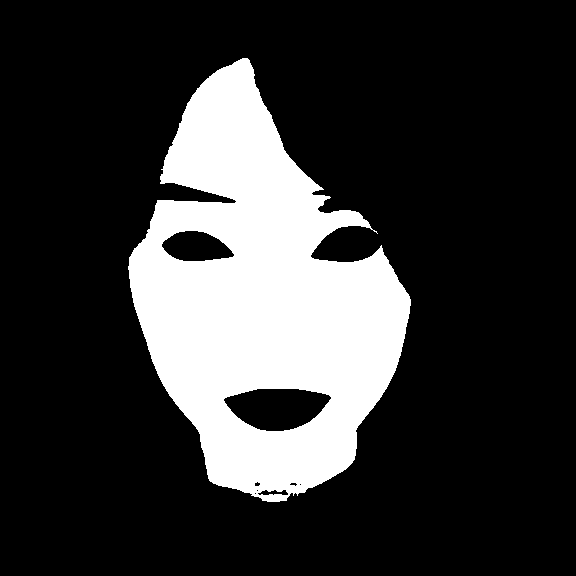

In [13]:
face_mask

In [15]:
face_masked = Image.open("output/face-masked_00001_.png")
face_masked_rgb = np.array(face_masked)
#face_masked_cielab = rgb_to_lab(face_masked_rgb)
#face_colors = face_masked_cielab[boolean_mask]  #.shape # (69512, 3)

In [395]:
face_colors.shape # 69512, 3

(69512, 3)

In [396]:
mu = face_colors.mean(axis=0)
sigma = face_colors.std(axis=0)
# mu, sigma

In [397]:
face_palette = np.array([
    [mu-sigma],
    [mu],
    [mu+sigma]
])
face_palette#.shape

array([[[-9.48231711, -9.52696651, -9.58033195]],

       [[ 3.74081748,  3.77490952,  3.79814878]],

       [[16.96395208, 17.07678555, 17.17662951]]])

In [390]:
lab_to_rgb(face_palette) # uh... negative RGB? no bueno

array([[[-206.30464592,   41.14269481,   49.02050532]],

       [[-170.73405421,   37.45373831,   41.67479433]],

       [[ -73.76876733,   22.72283582,   22.47787257]]])

In [388]:
lab_to_rgb(np.array([[mu]]))

array([[[22.78862419, 10.33720704,  4.56371884]]])

In [391]:
lab_to_rgb(np.array([[mu-sigma]])) # nonsensical..

array([[[-70.41469225, -26.2411024 , -11.68156573]]])

In [392]:
lab_to_rgb(np.array([[mu+sigma]])) # nonsensical..

array([[[69.20610431, 30.97651518, 17.77311051]]])

In [403]:
%pip install colorspacious

Note: you may need to restart the kernel to use updated packages.


# COLORSPACIOUS MAKES SHIT EASIER

In [10]:
# https://colorspacious.readthedocs.io/en/latest/
from colorspacious import cspace_convert, cspace_converter


In [69]:
# https://colorspacious.readthedocs.io/en/latest/reference.html#specifying-colorspaces
#face_masked_cie = cspace_convert(face_masked_rgb[boolean_mask], "sRGB255", "CIELab")
face_masked_cie = cspace_convert(face_masked_rgb[boolean_mask], "sRGB255", "CIELab")
mu_cielab = face_masked_cie.mean(axis=0) # well, that sure is quite different.
mu_cielab

array([73.86254922,  7.69678143, 11.56040397])

In [70]:
# https://arxiv.org/pdf/2309.05148.pdf
#np.arctan2
l,a,b = mu_cielab
h = np.arctan(b/a)
(l,h)

(73.86254921509871, 0.9834020864381342)

In [71]:
np.arctan2(b,a) # oh neat, same thing. goody.
# next... let's use CIECAM02

0.9834020864381342

In [72]:
mu_rgb = cspace_convert(mu_cielab, "CIELab", "sRGB255")
mu_rgb = mu_rgb.round().astype('int')
print(mu_rgb)

[204 176 161]


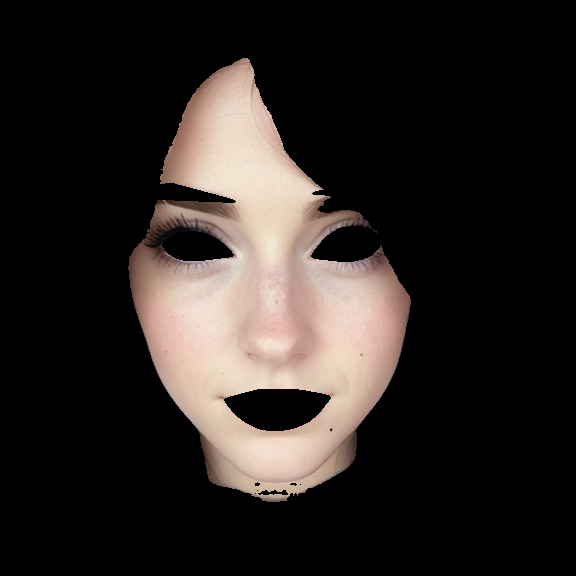

In [20]:
face_masked

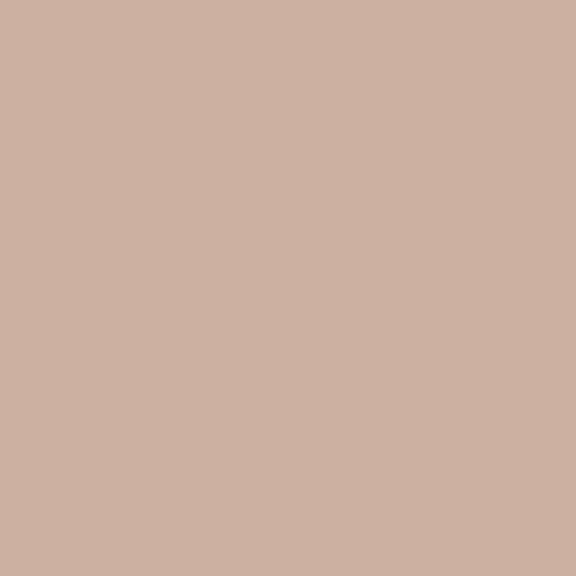

In [21]:
skin_tone = deepcopy(face_masked)
skin_tone.paste( tuple(mu_rgb), (0, 0, skin_tone.size[0], skin_tone.size[1]))
skin_tone

In [22]:
import sklearn
from sklearn.cluster import KMeans
#sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init='warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')[source]¶

> We cluster the face skin into five groups and keep the top-3 groups with the highest L∗ to compute the final L∗ and h∗ scalar scores for the image. Such approach is inspired by how human artists would perform value grouping in five different groups when simplifying an image. -- https://arxiv.org/pdf/2309.05148.pdf

In [23]:
cluster_model = KMeans(n_clusters=5)
y = cluster_model.fit_predict(face_masked_cie)

/Users/dmarx/proj/ComfyUI/_venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [24]:
np.bincount(y)

array([21353,  6779, 25310, 13008,  3062])

In [44]:
np.bincount(y).argsort()[::-1]

array([2, 0, 3, 1, 4])

In [25]:
# to do: visualize skin tone by cluster, reported alongside cluster size and luminance
class_labels = np.unique(y)
class_labels

array([0, 1, 2, 3, 4], dtype=int32)

In [35]:
from IPython import display

In [37]:
display.display

<function IPython.core.display_functions.display(*objs, include=None, exclude=None, metadata=None, transient=None, display_id=None, raw=False, clear=False, **kwargs)>

In [40]:
help(sorted)

Help on built-in function sorted in module builtins:

sorted(iterable, /, *, key=None, reverse=False)
    Return a new list containing all items from the iterable in ascending order.
    
    A custom key function can be supplied to customize the sort order, and the
    reverse flag can be set to request the result in descending order.



21353
(77.9394234330164, 0.9623656211460969)


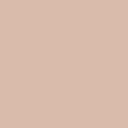

6779
(49.18874284816782, 0.7918441417055355)


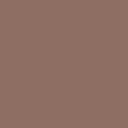

25310
(86.6476575091326, 1.1922217692221468)


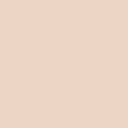

13008
(66.46517695899048, 0.835828299936695)


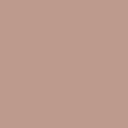

3062
(25.803818180325123, 0.7388069791466616)


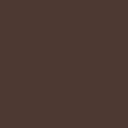

In [55]:
#cluster_model.labels_
#dir(cluster_model)

cluster_metadata = {} # cluster_id:{n, mu_l, mu_h, mu_rgb, skin_tone}

for cluster_id in range(cluster_model.n_clusters):
    idx = np.where(y==cluster_id)
    cluster_members = face_masked_cie[idx]
    mu_cluster = cluster_members.mean(axis=0)
    l,a,b = mu_cluster
    h = np.arctan(b/a)
    n = cluster_members.shape[0]
    print(n)
    #print(mu_cluster)
    print((l, h))

    mu_rgb = cspace_convert(mu_cluster, "CIELab", "sRGB255")
    mu_rgb = mu_rgb.round().astype('int')

    skin_tone = deepcopy(face_masked)
    skin_tone.paste( tuple(mu_rgb), (0, 0, skin_tone.size[0], skin_tone.size[1]))
    display.display(skin_tone.resize((128,128)))

    cluster_metadata[cluster_id]=dict(
        cluster_id=cluster_id,
        n = n,
        l=l,
        h=h,
        lab=mu_cluster,
        rgb=mu_rgb,
        skin_tone_image=skin_tone,
    )

[204 176 161]


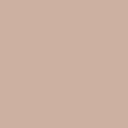

In [66]:
# drop lowest luminance i guess
#from operator import itemgetter
#sorted(cluster_metadata, key=itemgetter("l"))

# fuck it, there's only 5 anyway. don't make it harder than it needs to be.
# not gonna be a bottleneck.

luminances = [item['l'] for item in cluster_metadata.values()]
assert len(luminances) == 5
threshold = sorted(luminances)[::-1][-2]
keepers = {k:v for k,v in cluster_metadata.items() if v['l'] > threshold}
assert len(keepers) == 3

total_pixels = sum(v['n'] for v in cluster_metadata.values())
total_pixels

face_mu_cielab = np.array([0,0,0])
for item in cluster_metadata.values():
    weight = item['n'] / total_pixels
    face_mu_cielab = face_mu_cielab + weight * item['lab']

mu_rgb = cspace_convert(face_mu_cielab, "CIELab", "sRGB255")
mu_rgb = mu_rgb.round().astype('int')
print(mu_rgb)

# this is identical to what we got earlier
skin_tone = deepcopy(face_masked)
skin_tone.paste( tuple(mu_rgb), (0, 0, skin_tone.size[0], skin_tone.size[1]))
display.display(skin_tone.resize((128,128)))

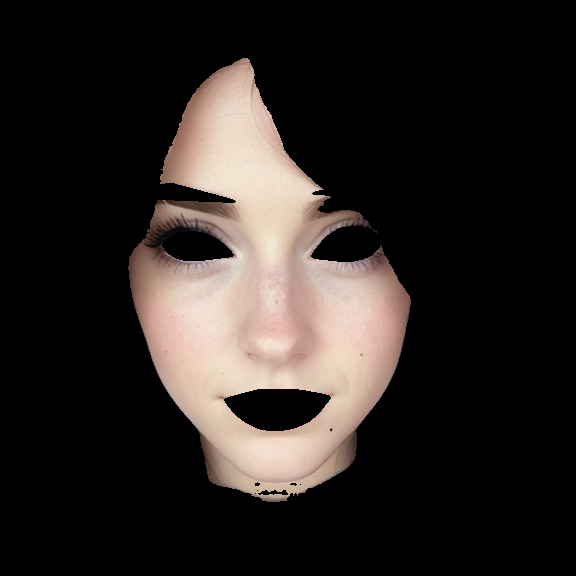

In [65]:
face_masked

In [ ]:
# TO DO:
# * save out metadata
# * save out estimated face tone as RGB, and <l,h> coordinate
# * after scoring a bunch of faces, plot an <l,h> color grid, add level curves to visualize model's racial prior